## ASTR 597A Homework 4
Eric Bellm

Due Jan 31, 2023

Your name: David
    
Your collaborators: Tobin

## Installation

This homework does not use the DP0.2 simulated data, and the `rubin_sim` package that includes the Metrics Analysis Framework (MAF) is not installed by default on `data.lsst.cloud`.  You may install and run `rubin_sim` on the `data.lsst.cloud` RSP instance, on your personal computer, or on a shared server like `epyc`.

You will need to install the `rubin_sim` package according to the directions at https://github.com/lsst/rubin_sim.

You can get more information about MAF from https://rubin-sim.lsst.io/ as well as the [rubin_sim_notebooks](https://github.com/lsst/rubin_sim_notebooks) tutorial notebooks; some of this material was adapted from those tutorials.

Note that in late 2022 many of the APIs in MAF were changed, as discussed in the [release notes](https://github.com/lsst/rubin_sim/releases), so you may find older materials which require some adjustment to use.

## Setup

Let's confirm that rubin_sim is working and that we can use MAF on the current baseline cadence.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import rubin_sim
from rubin_sim import maf
from rubin_sim.maf.run_comparison import archive
rubin_sim.__version__

'1.0.0'

In [3]:
opsim_fname = rubin_sim.data.get_baseline()
print(opsim_fname)

/Users/ykwang/rubin_sim_data/sim_baseline/baseline_v3.0_10yrs.db


In [4]:
from os.path import splitext, basename

run_name = splitext(basename(opsim_fname))[0]
print(run_name)

baseline_v3.0_10yrs


At the time of this writing the baseline is `baseline_v3.0_10yrs`.

Let's find a basic metric to run.  `CoaddM5` is provides the final coadded depth of the ten-year survey:

In [5]:
# list all pre-installed metrics
# maf.BaseMetric.help()

In [6]:
#help(maf.Coaddm5Metric)

Let's make plots of this metric for the `r` band as a spatial (healpix) map as well as a 1-d histogram, and then compute some summary statistics.

In [7]:
# choose the spatial slicer
slicer = maf.slicers.HealpixSlicer(nside=64)

# choose the metric
metric =  maf.metrics.Coaddm5Metric()

# only r-band
constraint = "filter = 'r'"

# choose how to plot"
plot_funcs = [maf.plots.HealpixSkyMap(), maf.plots.HealpixHistogram()]
plot_dict = {'nside': 64, 'colorMin': 0}

# define the summary metrics
summary_metrics = [maf.metrics.MinMetric(), maf.metrics.MedianMetric(), maf.metrics.MaxMetric(), 
                 maf.metrics.PercentileMetric(percentile=25), maf.metrics.PercentileMetric(percentile=75)]

# wrap it up
bundle = maf.metricBundles.MetricBundle(metric, slicer, constraint=constraint, run_name=run_name,
                                        plot_dict=plot_dict, plot_funcs=plot_funcs,
                                        summary_metrics=summary_metrics)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


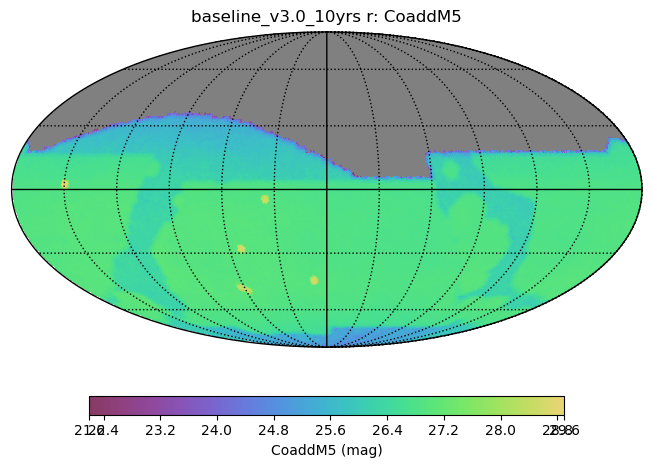

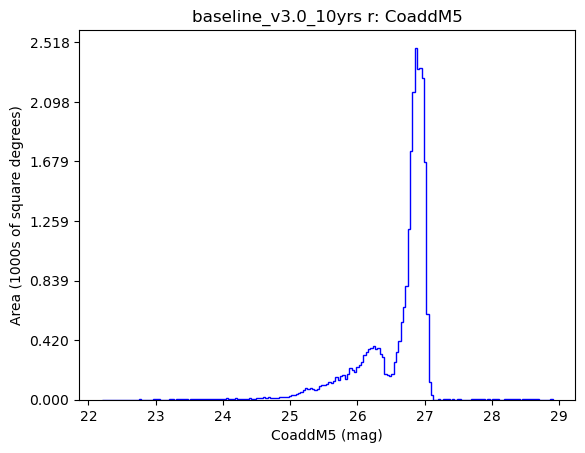

In [8]:
# out_dir = 'example'
#set and output dir
out_dir = 'sim_outputs'

bdict = {'example':bundle}
bgroup = maf.metricBundles.MetricBundleGroup(bdict, opsim_fname, out_dir=out_dir)
bgroup.run_all()
bgroup.plot_all(closefigs=False)

In [9]:
bdict['example'].summary_values

{'Min': 22.198008581186244,
 'Median': 26.818286779940127,
 'Max': 28.901333351511354,
 '25th%ile': 26.36466151384583,
 '75th%ile': 26.923352127895672}

## Exercise 1: Counts

Let's get a sense of how the LSST divides its exposures.  Use `UniSlicer`, `CountMetric`, and appropriate SQL constraints to provide counts of the total exposures by filter.  The OpSim schema is described [here](https://rubin-sim.lsst.io/rs_scheduler/output_schema.html).

In [10]:
#set and output dir
out_dir = 'sim_outputs'

# use UniSlicer to get all obs
slicer = maf.slicers.UniSlicer()

# choose the metric
metric =  maf.metrics.CountMetric(col='cloud')

obs_per_band = {}

for band in 'ugrizy':
    constraint = "filter = '{}'".format(band)
    test = maf.metricBundles.MetricBundle(metric, slicer, constraint=constraint, run_name=run_name)

    example1_bg = maf.MetricBundleGroup(
        [test], opsim_fname, out_dir
    )

    example1_bg.run_all()


    print(band, test.metric_values)
    obs_per_band[band] = test.metric_values[0]

u [112379.0]
g [190012.0]
r [483457.0]
i [494436.0]
z [405122.0]
y [400673.0]


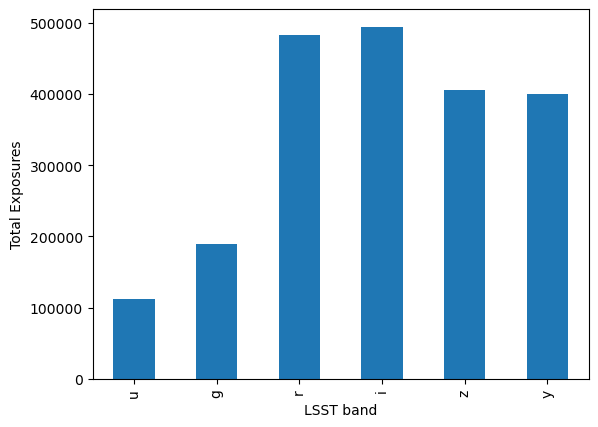

In [11]:
pd.Series(obs_per_band, name='Obs').plot.bar()
plt.xlabel('LSST band')
plt.ylabel('Total Exposures')
plt.show()

## Exercise 2: Cloudy

What is the mean cloud cover for exposures taken during the simulated baseline survey?  Plot a histogram of the cloud cover.

In [12]:
cloud_opsim_db = opsim_fname
cloud_slicer = maf.OneDSlicer(
    slice_col_name="cloud", bin_min=0, bin_max=1, binsize=0.05
)
cloud_metric = maf.CountMetric(col="cloud")
cloud_bundle = maf.MetricBundle(
    cloud_metric,
    cloud_slicer,
    run_name=run_name,
    summary_metrics=[maf.metrics.MeanMetric()]
)

In [13]:
cloud_bg = maf.MetricBundleGroup(
    [cloud_bundle], cloud_opsim_db, out_dir
)

cloud_bg.run_all()

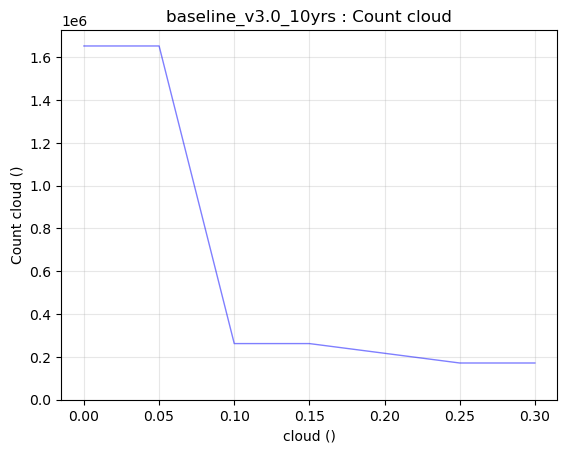

In [14]:
cloud_bg.plot_all(closefigs=False)

### plot using a step function so it looks nicer

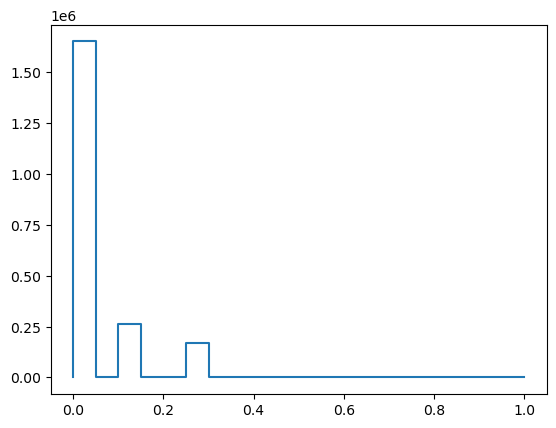

In [15]:
cloud_data = cloud_bundle.metric_values.data
cloud_bins=cloud_bundle.slicer.slice_points['bins']

plt.step(cloud_bins, [0] + list(cloud_data))
plt.show()

#### Take a weighted average to find average cloud cover

In [16]:
sum(cloud_data * cloud_bins[:-1]) / sum(cloud_data)

0.033127892088458774

The mean cloud cover is about 3.3%

## Exercise 3: Comparisons

MAF was built to compare evaluate the impact of different observing strategies on various science cases.  You can always write new metrics and run them yourself on multiple OpSim simulations.  This can be time consuming, though.  For many standard metrics, the metric values for various runs are stored in queryable tables--see the [04_Getting_Data](https://github.com/lsst/rubin_sim_notebooks/blob/main/maf/tutorial/04_Getting_Data.ipynb) tutorial notebook.

### 3a

In this exercise we'll get a small taste of the tradeoffs confronted by the Survey Cadence Optimization Committee.

Make a mesh plot of the metric summary values for the metric sets `"DESC WFD"` (Cosmology), `"TVS XRB"` (Galactic Transients), and `"SSO discovery"` (Solar System science) on run families `"baseline"`, `"galactic plane footprint"`, amd `"rolling"`.  Set `baseline_run='baseline_v2.0_10yrs'` to compare to one of the earlier baseline cadences.  Qualitatively, how does the new (v3.0) baseline cadence look for these metrics?  What other trends do you see across these run families?  

In [17]:
# get all metric sets 
metric_sets = maf.get_metric_sets()

# get all families 
families = maf.get_family_descriptions()

# get all family runs
family_runs = maf.get_family_runs()

# set baseline_run to current baseline
baseline_run = "baseline_v3.0_10yrs"

# set the metrics and runs we want to look at
this_metric_set = ["DESC WFD", "TVS XRB", "SSO discovery"]
this_family = ["baseline", "galactic plane footprint", "rolling"]

In [18]:
path_to_summaries = '../data/summary_2023_01_01.csv'

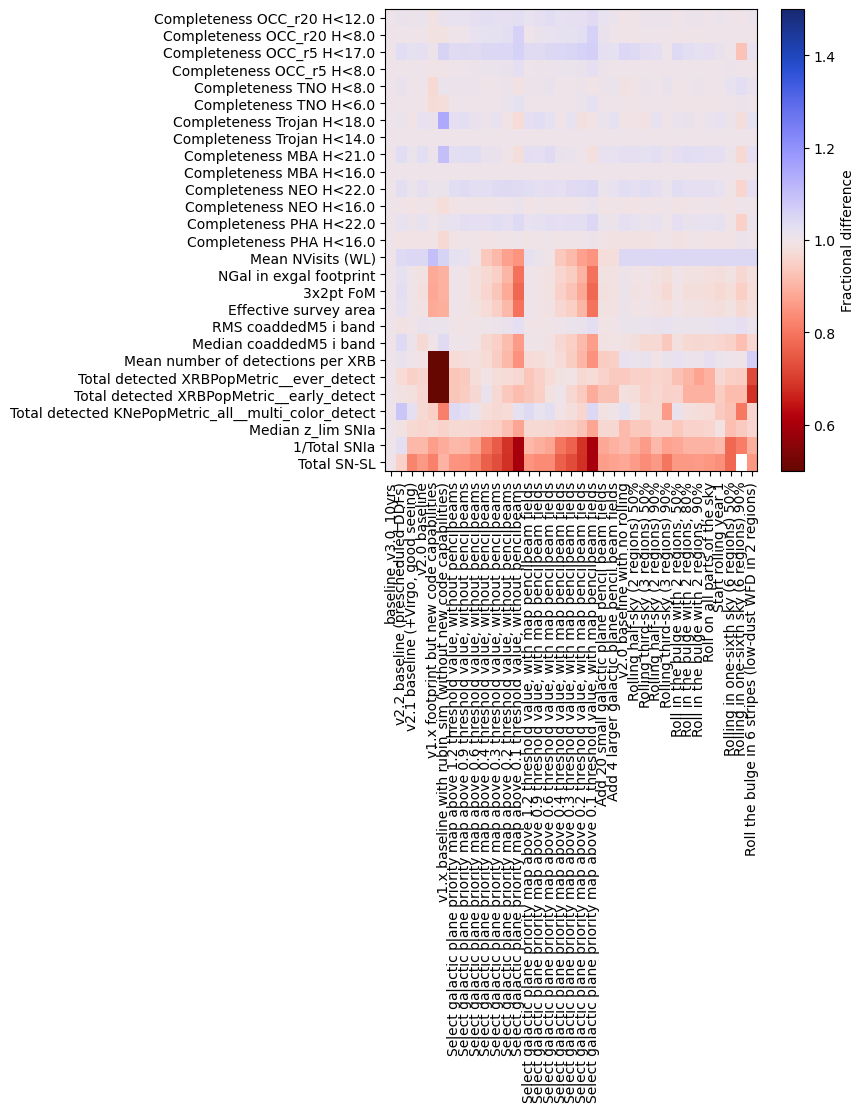

In [19]:
metric_label_map = metric_sets.loc[this_metric_set, "short_name"].droplevel(
    "metric set"
)

run_label_map = family_runs.loc[this_family, ["run", "brief"]].set_index("run")["brief"]

# change label for baseline run because it's massive
run_label_map[baseline_run] = baseline_run

summary = maf.get_metric_summaries(this_family, this_metric_set, summary_source=path_to_summaries)

maf.plot_run_metric_mesh(
    summary,
    baseline_run=baseline_run,
    metric_set=metric_sets.loc[this_metric_set],
    run_label_map=run_label_map,
    metric_label_map=metric_label_map,
)
plt.show()

### v3 baseline compared to other families of cadences
Compared with other families of cadences, the v3 baseline is particularly better for cosmology and detection of SNe. The galactic plane priority maps degrade performance for SN detection, particularly as the threshold decreases, as well as for weak lensing and effective survey area. It also leads to fewer detections of XRBs, surprisingly. This family of surveys boosts the discovery of SSOs, particularly faint SSOs and oort cloud comets--although I'm not sure why. This may be due to greater sampling of the ecliptic plane in these surveys.The alternate rolling cadences also decrease detection of SN, but benefit weak lensing cosmology. The v1.x cadences completely tank the observations of XRBs, which I can only assume means that this survey strategy avoided the plane and the bulge while giving some of that time to ecliptic surveys.

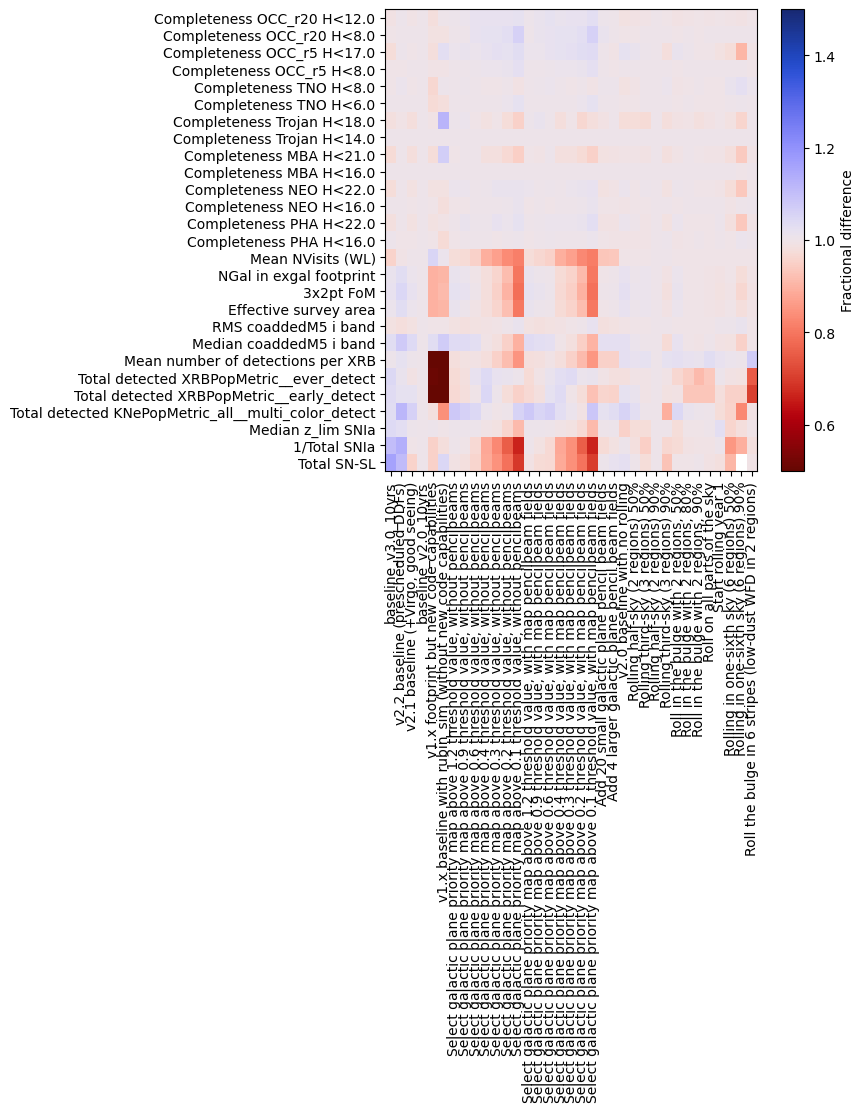

In [20]:
# set baseline_run to prev baseline
baseline_run = "baseline_v2.0_10yrs"
run_label_map[baseline_run] = baseline_run

summary = maf.get_metric_summaries(this_family, this_metric_set, summary_source=path_to_summaries)

maf.plot_run_metric_mesh(
    summary,
    baseline_run=baseline_run,
    metric_set=metric_sets.loc[this_metric_set],
    run_label_map=run_label_map,
    metric_label_map=metric_label_map,
)
plt.show()

### v3 baseline compared to v2 baseline
Compared to v2, the v3 baseline tends to be better for some Cosmology targets detecting supernovae, particularly superlumnious supernovae, while very slightly worse at detecting solar system objects, particularly fainter SSOs. The v3 baseline has fewer mean visits, which is worse for weak lensing. There is also some improvement to detection rates of galactic transients (i.e. XRBs) and to kilanovae. 

### 3b (optional)

Look through the list of metric sets and identify which one(s) are most closely associated with your scientific interests.  What has been the trend of these metrics in the `"baseline"` run family?  Make a plot with `maf.plot_run_metric`.

## Exercise 4: Lightcurves

Some metrics take simulated events and generate the data points as they would be observed by LSST.  Typically these lightcurves are only used internally to compute higher-level metrics, but some metrics make it possible to return the generated lightcurves.

Use the `KNePopMetric` with `output_lc=True` to generate random kilonova lightcurves as observed by LSST.  Plot an event with at least ten data points.

The [kilonova](https://github.com/lsst/rubin_sim_notebooks/blob/main/maf/science/KNeMetric.ipynb) and [XRB](https://github.com/lsst/rubin_sim_notebooks/blob/main/maf/science/XRB_Metric.ipynb) science notebooks will be helpful.

In [21]:
import os
baseline_file = rubin_sim.data.get_baseline()
opsim = os.path.basename(baseline_file).replace('.db','')

In [22]:
# create 25000 events
n_events = 25000

# Kilonova parameters - set up to run on a particular subset of the KNe models
# All models
filename = maf.get_kne_filename(None)
slicer_all = maf.generate_kn_pop_slicer(n_events=n_events, n_files=len(filename), d_min=10, d_max=600)
metric_all = maf.KNePopMetric(output_lc=True, file_list=filename, metric_name='KNePopMetric_all')

In [23]:
# These summary metrics are now available as 'batches.lightcurveSummary' 
# (i.e. summaryMetrics = maf.lightcurveSummary())
summaryMetrics = [maf.SumMetric(metric_name='Total detected'), 
                  maf.CountMetric(metric_name='Total lightcurves in footprint'),
                  maf.CountMetric(metric_name='Total lightcurves on sky', mask_val=0),
                  maf.MeanMetric(metric_name='Fraction detected in footprint'), 
                  maf.MeanMetric(mask_val=0, metric_name='Fraction detected of total')]

In [24]:
bundle_all = maf.MetricBundle(metric_all, slicer_all, None, 
                              info_label='all models', run_name=opsim, summary_metrics=summaryMetrics)

In [25]:
bdict = {'all': bundle_all}
g = maf.MetricBundleGroup(bdict, baseline_file, out_dir)

In [26]:
g.run_all()

In [27]:
# from the XRB metrics notebook
def get_lc(v):
    """Extract lightcurves saved with `outputLc=True` from the metric datastructure
    
    Parameters
    ----------
    v : `metricValue`
        Input metricValue containing the lightcurve
    
    Returns
    -------
    lc : dict
        dict with columns `t`, `mag`, `mag_unc`, `maglim`, `filter`
    """
    if v is not None:
        return v['lc']
    else:
        return None
    
lcs = [get_lc(v) for v in bdict['all'].metric_values.tolist()]

In [28]:
len(lcs)

25000

In [29]:
# Adapted from XRB notebook
def plot_lc(lc, min_len=10):
    """Helper function to plot lightcurves stored by MAF.
    """
    colors = {'u':'purple','g': 'b', 'r': 'g', 'i':'orange', 'z':'red', 'y':'brown' }
    if lc is None:
        # print('No Lightcurve')
        return 0
    df = pd.DataFrame(lc).T
    df.columns = ['t', 'mag', 'magerr', 'maglim', 'filt']
    df = df.query('mag != 99')
    df = df.query('mag < 30')
    # df['mag'] < 30
    if len(df) < min_len:
        # print('Lightcurve too undersampled')
        return 0
    plt.figure()
    for f in np.unique(df['filt']):
        w = (df['filt'] == f) & (df['mag'] < 30)
        plt.errorbar(df['t'][w],df['mag'][w],df['magerr'][w],fmt='.',color=colors[f],linestyle='none',label=f, alpha=.7)
    plt.legend()
    
    plt.xlabel('Time (MJD)')
    plt.ylabel('Magnitude')

    plt.gca().invert_yaxis()
    plt.show()
    return 1

#### Here's an event only seen on one night (must be in a deep drilling field)

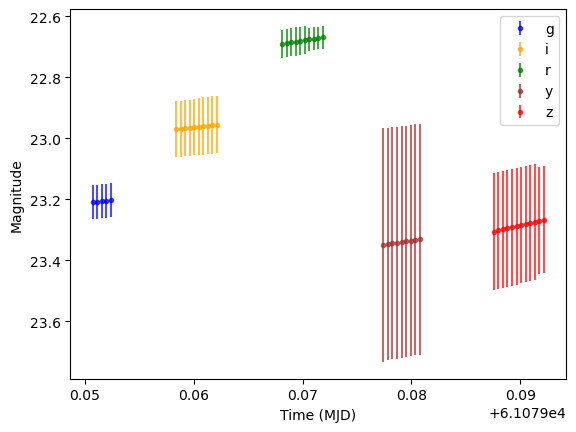

In [36]:
_ = plot_lc(lcs[0])       

#### Here's an event where the color evolution is espcially easy to see

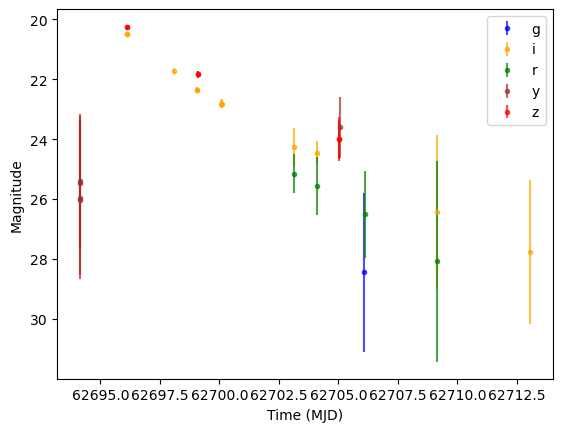

In [37]:
_ = plot_lc(lcs[1])       